## Imports

In [23]:
from torch.utils.data import DataLoader
import torch
import matplotlib.pyplot as plt
import importlib

### Loading Repo

In [24]:
!git clone -b talib-1 http://github.com/Zapy67/ATML-PA-2

Cloning into 'ATML-PA-2'...
remote: Enumerating objects: 527, done.
remote: Counting objects: 100% (199/199), done.
remote: Compressing objects: 100% (125/125), done.
remote: Total 527 (delta 128), reused 141 (delta 74), pack-reused 328 (from 1)
Receiving objects: 100% (527/527), 18.25 MiB | 35.60 MiB/s, done.
Resolving deltas: 100% (306/306), done.


In [135]:
!git pull http://github.com/Zapy67/ATML-PA-2 talib-1

From http://github.com/Zapy67/ATML-PA-2
 * branch            talib-1    -> FETCH_HEAD
Already up to date.


In [25]:
%cd ATML-PA-2/

/kaggle/working/ATML-PA-2/DANN & CDAN/ATML-PA-2


In [27]:
%cd "DANN & CDAN"

/kaggle/working/ATML-PA-2/DANN & CDAN/ATML-PA-2/DANN & CDAN


In [28]:
!ls

cdan.ipynb  CDAN.py  dann.ipynb  DANN.py  train.py  utils


In [96]:
from utils.dataset import MEAN, STD, OfficeHomeDataset
import utils
import os
from torchvision.models import ResNet50_Weights

importlib.reload(utils)

<module 'utils' from '/kaggle/working/ATML-PA-2/DANN & CDAN/ATML-PA-2/DANN & CDAN/utils/__init__.py'>

### Loading Dataset

In [30]:
root_dir = '/kaggle/input/officehome/OfficeHomeDataset_10072016'
csv_file = '/kaggle/input/officehome/OfficeHomeDataset_10072016/ImageInfo.csv'

In [31]:
import torchvision.transforms as transforms
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                        std=[0.229, 0.224, 0.225])
])

# Testing
test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                        std=[0.229, 0.224, 0.225])
])


In [32]:
# transform = ResNet50_Weights.IMAGENET1K_V1.transforms()
classes = os.listdir(f"{root_dir}/Art")

In [33]:
sources = ["Art", "Real World", "Product"]
target = ["Clipart"]
source_ds = utils.dataset.OfficeHomeDataset(root_dir, csv_file, sources, train_transform)
target_ds = utils.dataset.OfficeHomeDataset(root_dir, csv_file, target, test_transform)

(15913, 2)
                                           name  \
0  D:/Dataset10072016/Art/Alarm_Clock/00001.jpg   
1  D:/Dataset10072016/Art/Alarm_Clock/00002.jpg   
2  D:/Dataset10072016/Art/Alarm_Clock/00003.jpg   
3  D:/Dataset10072016/Art/Alarm_Clock/00004.jpg   
4  D:/Dataset10072016/Art/Alarm_Clock/00005.jpg   

                                                link  
0  http://img03.deviantart.net/6533/i/2012/052/0/...  
1  http://img07.deviantart.net/a073/i/2011/214/5/...  
2  http://img08.deviantart.net/955f/i/2011/226/b/...  
3  http://img06.deviantart.net/d6fe/i/2006/177/7/...  
4  http://orig04.deviantart.net/7945/f/2013/237/b...  
(15913, 2)
                                           name  \
0  D:/Dataset10072016/Art/Alarm_Clock/00001.jpg   
1  D:/Dataset10072016/Art/Alarm_Clock/00002.jpg   
2  D:/Dataset10072016/Art/Alarm_Clock/00003.jpg   
3  D:/Dataset10072016/Art/Alarm_Clock/00004.jpg   
4  D:/Dataset10072016/Art/Alarm_Clock/00005.jpg   

                                  

In [34]:
source_loader = DataLoader(source_ds, batch_size=32, shuffle=True, num_workers=2)
target_loader = DataLoader(target_ds, batch_size=32, shuffle=True, num_workers=2)

In [35]:
def denormalize(img_tensor, mean=MEAN, std=STD):
    """Undo normalization on a single image tensor (C,H,W) → numpy (H,W,C) in [0,1]."""
    img = img_tensor.clone().cpu()
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    img = img * std + mean
    img = img.permute(1, 2, 0).clamp(0, 1)
    return img.numpy()

In [36]:
def show_images_from_dataset(dataset, n=8, title="Sample Images"):
    """
    Displays 'n' random images from the OfficeHomeDataset with class names.
    """
    plt.figure(figsize=(3 * n, 3))
    indices = torch.randperm(len(dataset))[:n]

    for i, idx in enumerate(indices):
        img, label = dataset[idx]
        img = denormalize(img)
        label_name = list(dataset.class_to_idx.keys())[label]

        plt.subplot(1, n, i + 1)
        plt.imshow(img)
        plt.title(label_name, fontsize=9)
        plt.axis("off")

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


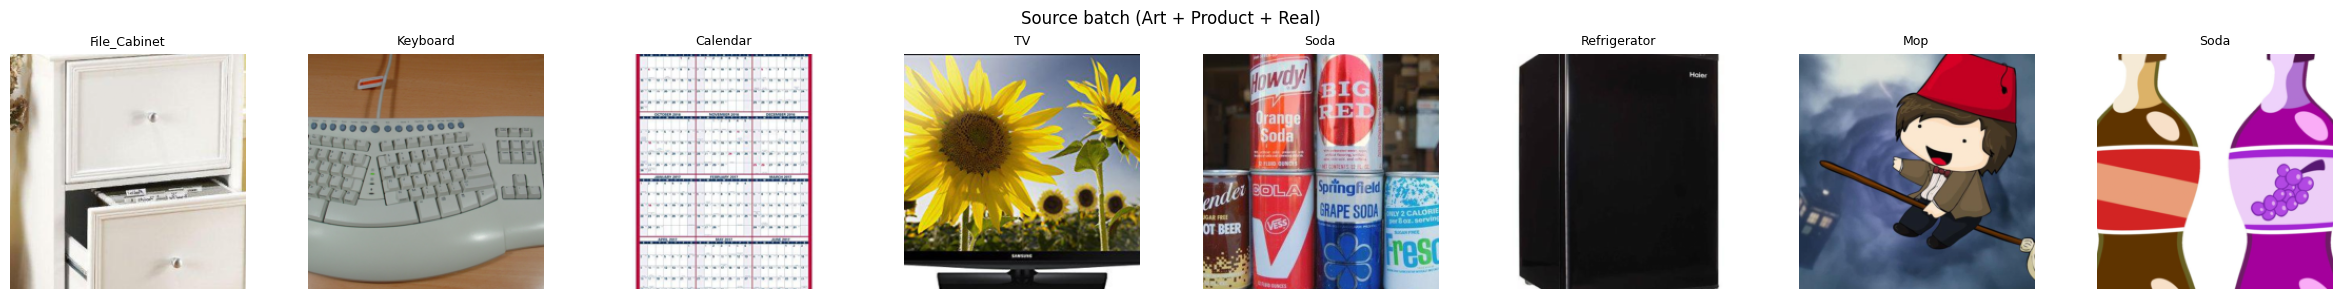

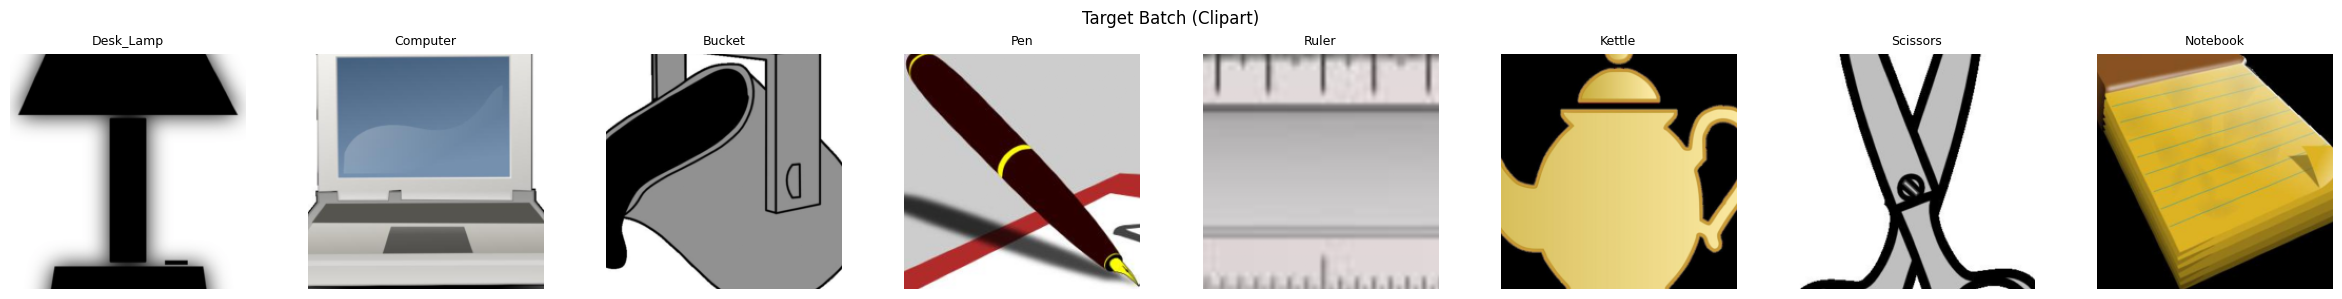

In [15]:
# show source images
show_images_from_dataset(source_ds, title="Source batch (Art + Product + Real)")
# show target images
show_images_from_dataset(target_ds, title="Target Batch (Clipart)")

## CDAN Training

In [37]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [122]:
import CDAN as cdan
importlib.reload(cdan)
importlib.reload(utils.dataset)

<module 'utils.dataset' from '/kaggle/working/ATML-PA-2/DANN & CDAN/ATML-PA-2/DANN & CDAN/utils/dataset.py'>

In [123]:
from utils.dataset import FeatureTensorDataset
from torchvision.models import resnet50, resnet18
from torchvision.models import ResNet18_Weights

In [40]:
import torch.nn as nn
class RestWrapper(nn.Module):
    """Wrap the `truncate_from(resnet, 'layer3')` module so it returns (B, D)
       and exposes output_dim attribute expected by DANN class."""
    def __init__(self, rest_module, output_dim=1024):
        super().__init__()
        self.rest = rest_module
        self.output_dim = output_dim

    def forward(self, featmap):
        out = self.rest(featmap)
        if out.dim() == 4:
            out = torch.flatten(out, 1)
        elif out.dim() == 2:
            # already flattened
            pass
        else:
            # keep guard
            out = out.view(out.size(0), -1)
        return out

In [41]:
def truncate_up_to(resnet: nn.Module, layer_name: str) -> nn.Sequential:
    seq = nn.Sequential()
    for name, module in resnet.named_children():
        seq.add_module(name, module)
        if name == layer_name:
            break
    return seq

def truncate_from(resnet: nn.Module, layer_name: str) -> nn.Sequential:
    seen = False
    seq = nn.Sequential()
    for name, module in resnet.named_children():
        if seen and name != 'fc':    # exclude final fc
            seq.add_module(name, module)
        if name == layer_name:
            seen = True
    return seq

def freeze_until(resnet: nn.Module, layer_name: str):
    freeze = True
    for name, module in resnet.named_children():
        if freeze:
            for p in module.parameters():
                p.requires_grad = False
        if name == layer_name:
            freeze = False

In [130]:
base_resnet = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
# base_resnet = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
freeze_until(base_resnet, 'layer3')

In [43]:
cache_source = utils.dataset.FeatureTensorDataset(dataset=source_ds, base_model=base_resnet, layer_name='layer3', device=device, batch_size=32, num_workers=2)
cache_target = utils.dataset.FeatureTensorDataset(dataset=target_ds, base_model=base_resnet, layer_name='layer3', device=device, batch_size=32, num_workers=2)

Precomputing up to layer3: 100%|██████████| 137/137 [00:33<00:00,  4.03it/s]


In [131]:
rest = truncate_from(base_resnet, 'layer3')
# rest = nn.Sequential(*list(base_resnet.children())[:-1])
rest_wrapper = RestWrapper(rest, output_dim=2048).to(device)
# rest_wrapper = RestWrapper(rest, output_dim=512).to(device)

In [136]:
model = cdan.CDAN(num_classes=65, resnet=rest_wrapper, use_entropy=True)

In [137]:
src_loader = DataLoader(cache_source, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
tgt_loader = DataLoader(cache_target, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)

In [138]:
trainer = cdan.CDANTrainer(
        model=model,
        device=device,
        learning_rate=1e-4,
        weight_decay=5e-4,
        gamma=8.0,
        max_grad_norm=3.0,
        label_smoothing=0.05,
        dl_weight=1.0
    )

In [139]:
trainer.train(source_loader=src_loader, target_loader=tgt_loader, num_epochs=11, discriminator_warmup_epochs=1) # first epoch disc warms up

Epoch 1/11: 100%|██████████| 351/351 [00:18<00:00, 18.49it/s, cls_loss=4.1343, dom_loss=1.3684, cls_acc=0.0000, alpha=0.0000]
                                                                    

Epoch 1/11 - Train Loss: 5.6445, Train Acc: 0.0196, Target Acc: 0.0179


Epoch 2/11: 100%|██████████| 351/351 [00:49<00:00,  7.06it/s, cls_loss=1.2937, dom_loss=1.3811, cls_acc=0.8261, alpha=0.3484]
                                                                    

Epoch 2/11 - Train Loss: 3.4992, Train Acc: 0.6484, Target Acc: 0.4708


Epoch 3/11: 100%|██████████| 351/351 [00:49<00:00,  7.16it/s, cls_loss=0.7224, dom_loss=1.4168, cls_acc=0.9130, alpha=0.6214]
                                                                    

Epoch 3/11 - Train Loss: 2.3808, Train Acc: 0.8364, Target Acc: 0.4946


Epoch 4/11: 100%|██████████| 351/351 [00:49<00:00,  7.15it/s, cls_loss=0.8602, dom_loss=1.3823, cls_acc=0.8696, alpha=0.7972]
                                                                    

Epoch 4/11 - Train Loss: 2.0158, Train Acc: 0.8888, Target Acc: 0.5033


Epoch 5/11: 100%|██████████| 351/351 [00:48<00:00,  7.18it/s, cls_loss=0.7973, dom_loss=1.4294, cls_acc=0.7826, alpha=0.8966]
                                                                    

Epoch 5/11 - Train Loss: 1.7923, Train Acc: 0.9299, Target Acc: 0.4987


Epoch 6/11: 100%|██████████| 351/351 [00:49<00:00,  7.16it/s, cls_loss=0.2616, dom_loss=1.3854, cls_acc=0.9565, alpha=0.9487]
                                                                    

Epoch 6/11 - Train Loss: 1.6435, Train Acc: 0.9605, Target Acc: 0.5095


Epoch 7/11: 100%|██████████| 351/351 [00:49<00:00,  7.15it/s, cls_loss=0.1541, dom_loss=1.3878, cls_acc=1.0000, alpha=0.9749]
                                                                    

Epoch 7/11 - Train Loss: 1.5423, Train Acc: 0.9802, Target Acc: 0.5022


Epoch 8/11: 100%|██████████| 351/351 [00:49<00:00,  7.15it/s, cls_loss=0.0912, dom_loss=1.3629, cls_acc=1.0000, alpha=0.9878]
                                                                    

Epoch 8/11 - Train Loss: 1.4748, Train Acc: 0.9921, Target Acc: 0.5058


Epoch 9/11: 100%|██████████| 351/351 [00:49<00:00,  7.15it/s, cls_loss=0.0504, dom_loss=1.3552, cls_acc=1.0000, alpha=0.9941]
                                                                    

Epoch 9/11 - Train Loss: 1.4366, Train Acc: 0.9968, Target Acc: 0.5068


Epoch 10/11: 100%|██████████| 351/351 [00:49<00:00,  7.13it/s, cls_loss=0.0131, dom_loss=1.4094, cls_acc=1.0000, alpha=0.9971]
                                                                    

Epoch 10/11 - Train Loss: 1.4203, Train Acc: 0.9980, Target Acc: 0.5120


Epoch 11/11: 100%|██████████| 351/351 [00:48<00:00,  7.18it/s, cls_loss=0.0251, dom_loss=1.3926, cls_acc=1.0000, alpha=0.9986]


Epoch 11/11 - Train Loss: 1.4097, Train Acc: 0.9995, Target Acc: 0.5095



=== SOURCE REPORT ===
              precision    recall  f1-score   support

 Alarm_Clock     1.0000    1.0000    1.0000       239
    Backpack     1.0000    1.0000    1.0000       239
   Batteries     1.0000    1.0000    1.0000       153
         Bed     1.0000    1.0000    1.0000       166
        Bike     1.0000    1.0000    1.0000       218
      Bottle     1.0000    1.0000    1.0000       239
      Bucket     1.0000    1.0000    1.0000       167
  Calculator     1.0000    1.0000    1.0000       187
    Calendar     1.0000    1.0000    1.0000       169
     Candles     1.0000    1.0000    1.0000       231
       Chair     1.0000    1.0000    1.0000       264
  Clipboards     1.0000    1.0000    1.0000       155
    Computer     1.0000    0.9951    0.9975       204
       Couch     1.0000    1.0000    1.0000       204
    Curtains     1.0000    1.0000    1.0000       188
   Desk_Lamp     1.0000    1.0000    1.0000       168
       Drill     1.0000    1.0000    1.0000       133
    

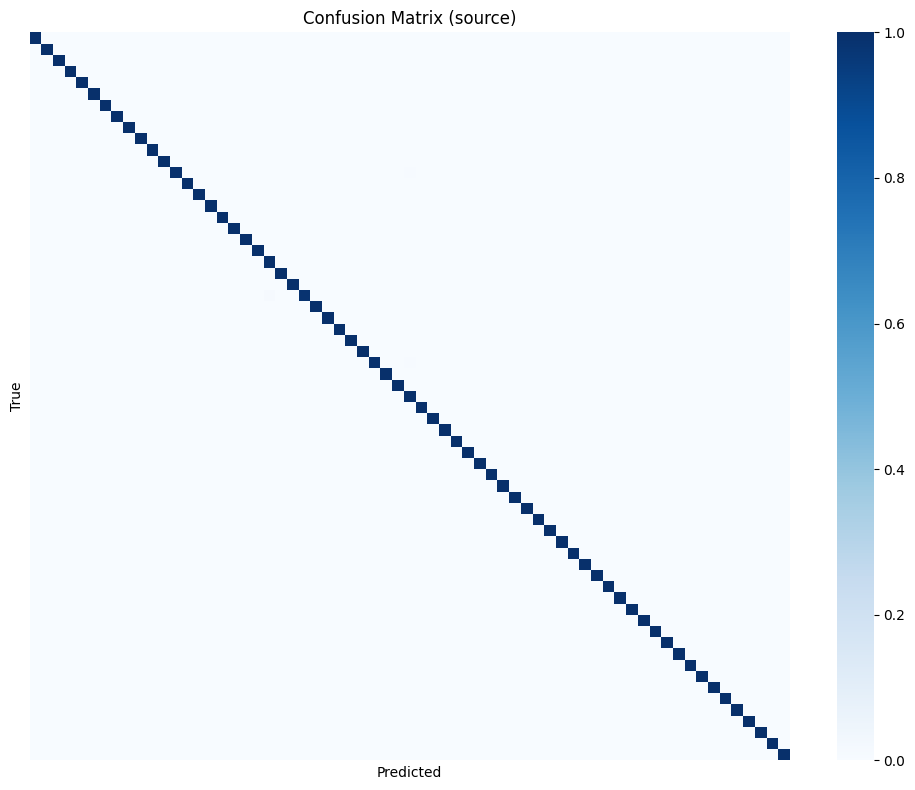

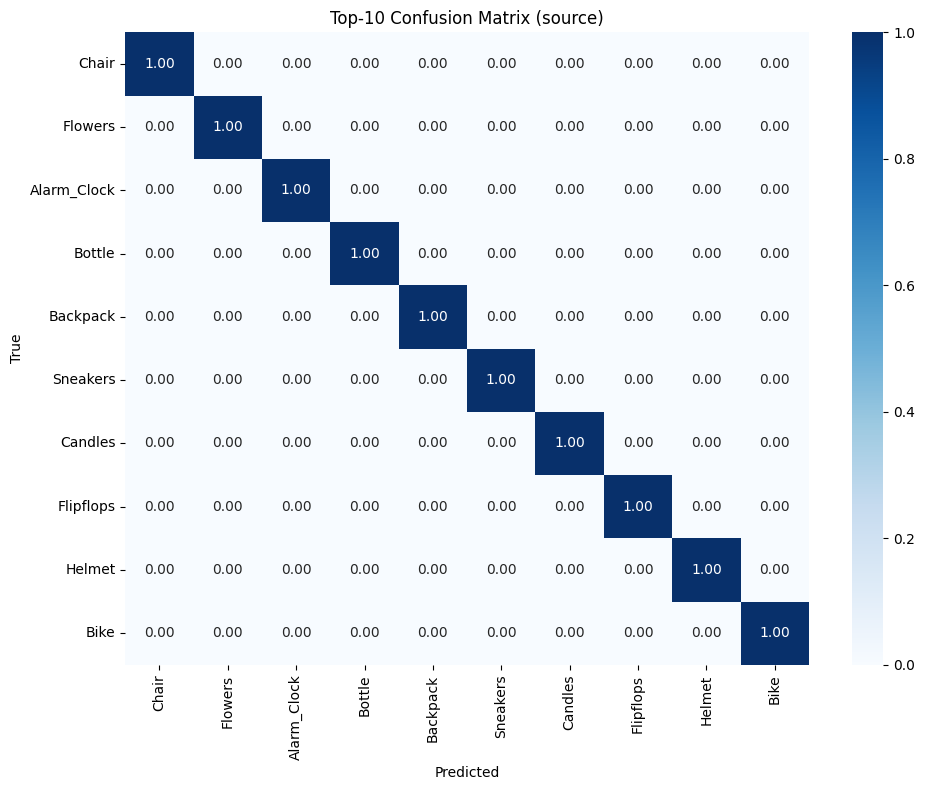


=== TARGET REPORT ===
              precision    recall  f1-score   support

 Alarm_Clock     0.5000    0.7500    0.6000        60
    Backpack     0.5254    0.5536    0.5391        56
   Batteries     0.6452    0.3125    0.4211        64
         Bed     0.7674    0.3367    0.4681        98
        Bike     0.9756    0.8081    0.8840        99
      Bottle     0.6604    0.3535    0.4605        99
      Bucket     0.4247    0.4247    0.4247        73
  Calculator     0.6349    0.8696    0.7339        46
    Calendar     0.5349    0.5897    0.5610        78
     Candles     0.3445    0.4141    0.3761        99
       Chair     0.5462    0.6566    0.5963        99
  Clipboards     0.1875    0.3000    0.2308        40
    Computer     0.4773    0.4242    0.4492        99
       Couch     0.7600    0.2969    0.4270        64
    Curtains     0.4821    0.6429    0.5510        42
   Desk_Lamp     0.1892    0.1707    0.1795        41
       Drill     0.8800    0.4583    0.6027        48
    

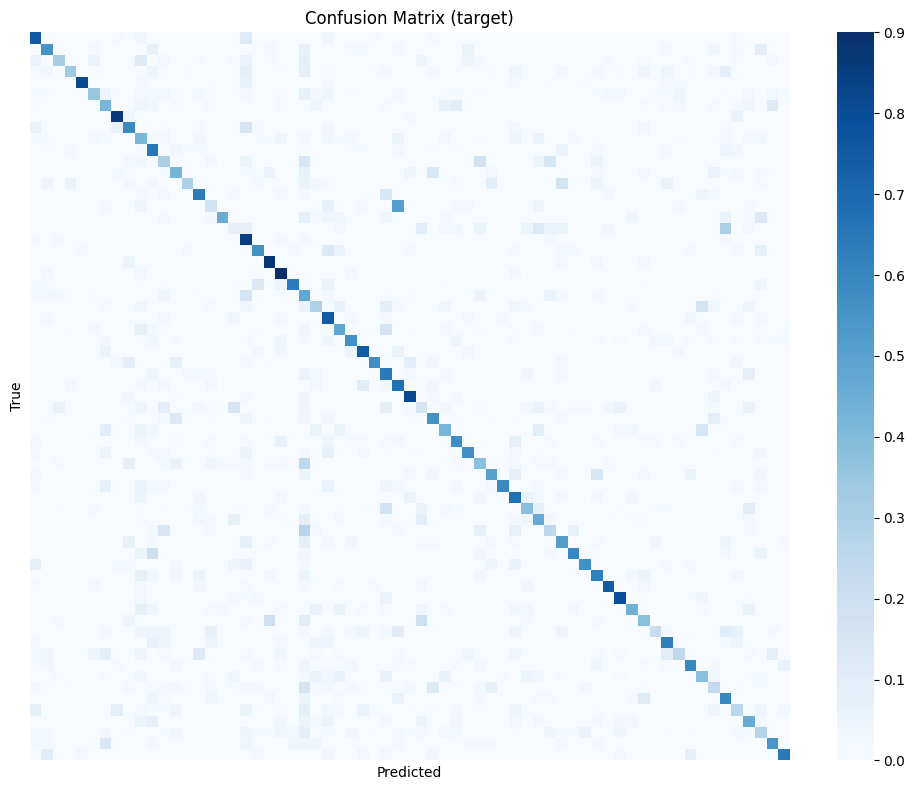

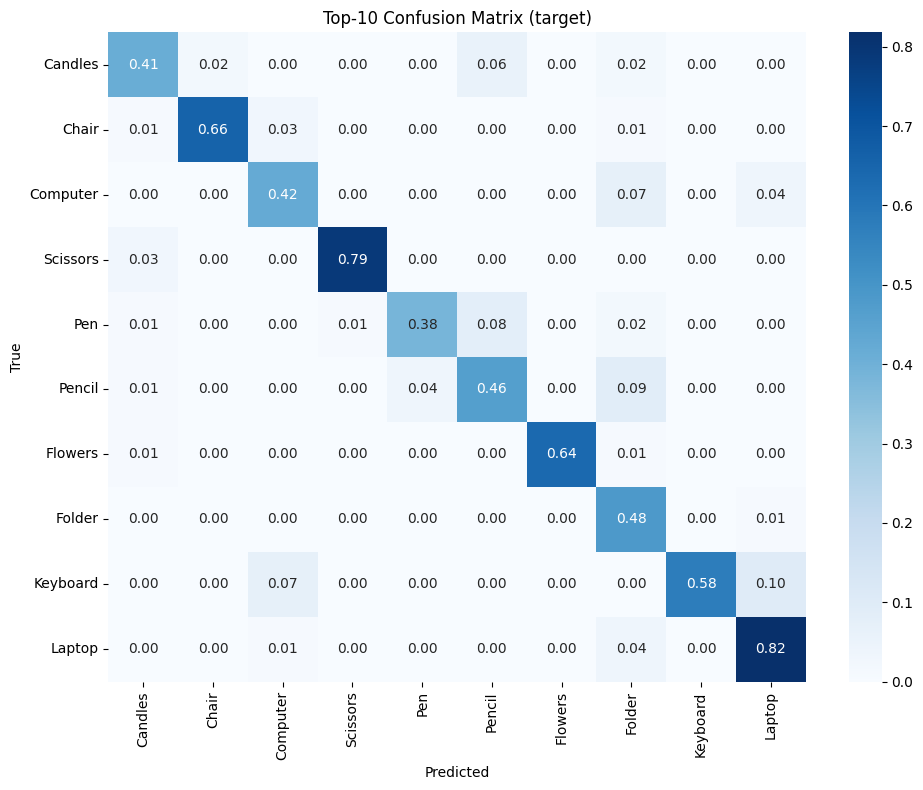

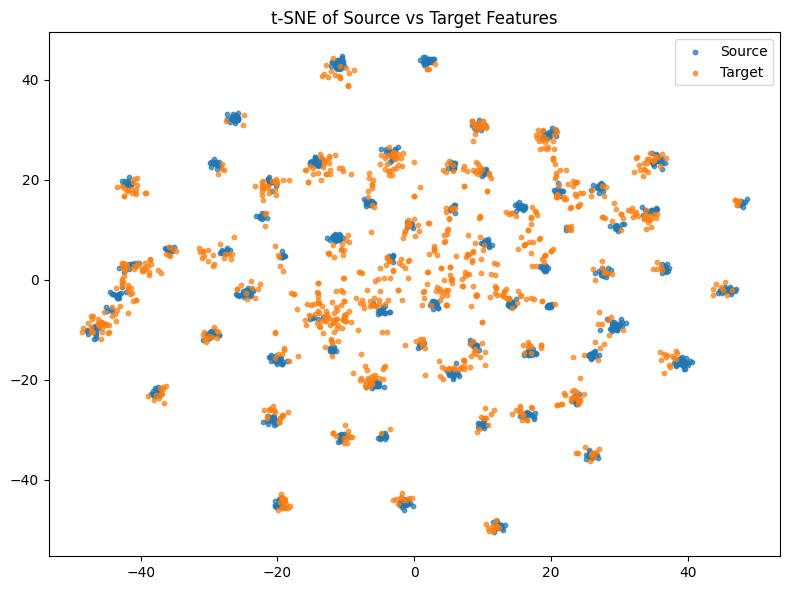

{'tsne': array([[-35.946095 ,   5.8814244],
        [-19.95131  , -16.25627  ],
        [  1.6351521,  43.709816 ],
        ...,
        [ 20.796253 ,  20.729956 ],
        [ 10.4767275, -27.757683 ],
        [-21.478346 , -27.708826 ]], dtype=float32),
 'source': {'report': '              precision    recall  f1-score   support\n\n Alarm_Clock     1.0000    1.0000    1.0000       239\n    Backpack     1.0000    1.0000    1.0000       239\n   Batteries     1.0000    1.0000    1.0000       153\n         Bed     1.0000    1.0000    1.0000       166\n        Bike     1.0000    1.0000    1.0000       218\n      Bottle     1.0000    1.0000    1.0000       239\n      Bucket     1.0000    1.0000    1.0000       167\n  Calculator     1.0000    1.0000    1.0000       187\n    Calendar     1.0000    1.0000    1.0000       169\n     Candles     1.0000    1.0000    1.0000       231\n       Chair     1.0000    1.0000    1.0000       264\n  Clipboards     1.0000    1.0000    1.0000       155\n    Co

In [140]:
trainer.analysis(src_loader, tgt_loader, class_names= source_ds.classes,random_state=42)